In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

## Loading Dataset

In [2]:
data_dir = 'data\\plates\\train'

In [3]:
img_height = 256
img_width = 256

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  )

Found 40 files belonging to 2 classes.
Using 32 files for training.
Found 40 files belonging to 2 classes.
Using 8 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['cleaned', 'dirty']


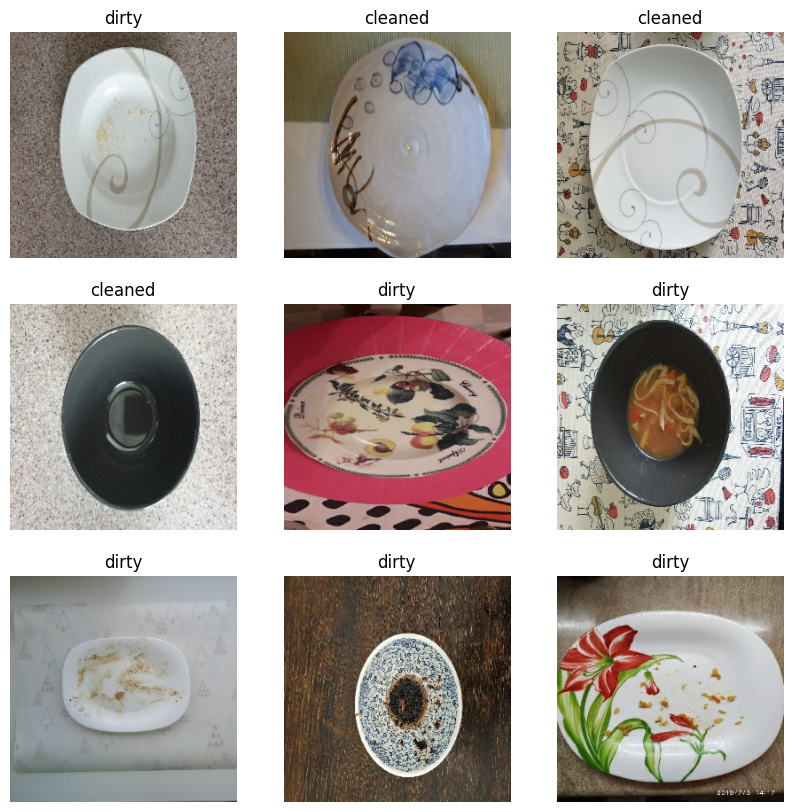

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data Augmentation

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),  # Horizontal flip
        layers.RandomRotation(0.9),  # Increase rotation range
        layers.RandomZoom(0.2),  # Increase zoom level for more scale variations
        layers.RandomContrast(0.4)  # Keep contrast adjustment
    ]
)


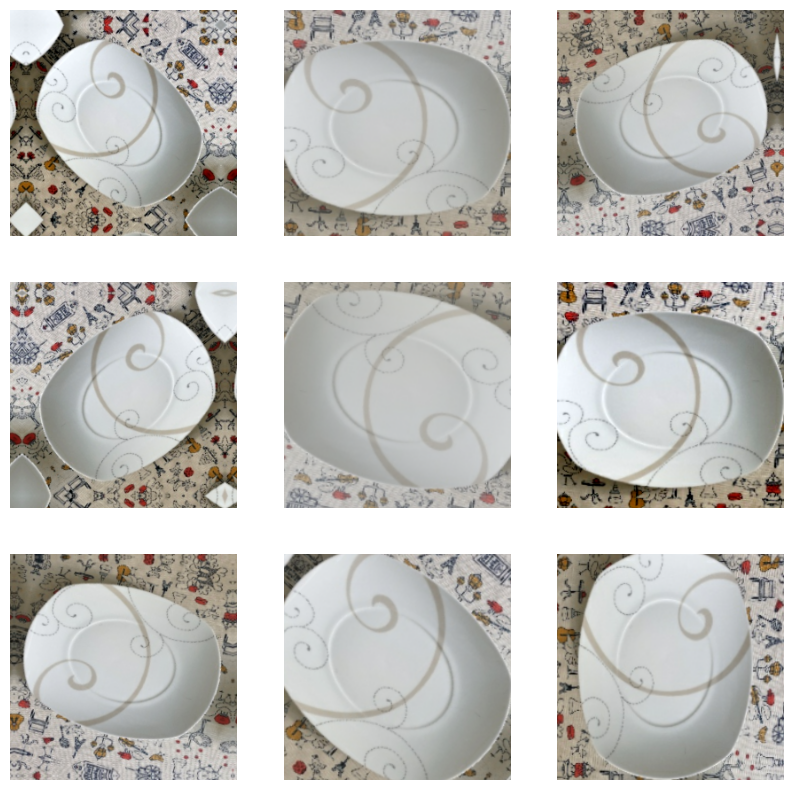

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [16]:
# apply data augmentation to the training dataset
# repeat 300 times and shuffle the data
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y)).repeat(100).shuffle(32)

In [17]:
augmented_train_ds # check the shape of the augmented dataset

<ShuffleDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [18]:
# size of the augmented dataset
print(len(augmented_train_ds))

100


In [19]:
train_ds # check the shape of the original dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
# size of the original dataset
print(len(train_ds)) 

1


## Build Deep Learning Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import relu, elu
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomCrop, RandomTranslation, RandomHeight, RandomWidth, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense


In [22]:
model = Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation,
    Conv2D(16, 3, padding='same', activation=relu),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),  # Dropout after pooling
    Conv2D(32, 3, padding='same', activation=relu),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),  # Additional dropout
    Conv2D(64, 3, padding='same', activation=relu),
    BatchNormalization(),
    MaxPooling2D(),
    GlobalAveragePooling2D(),
    Dense(128, activation=relu, kernel_regularizer=l2(0.01)),  # Added dense layer with regularization
    Dropout(0.5),  # High dropout rate for dense layer
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

In [23]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)     

## Model training

In [25]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

In [26]:
epochs=50

In [27]:
# Train the model
hist = model.fit(augmented_train_ds, epochs=epochs, validation_data=val_ds, callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/50
100/100 [==============================] - 47s 377ms/step - loss: 1.2087 - accuracy: 0.6309 - val_loss: 1.0701 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 31s 280ms/step - loss: 0.7946 - accuracy: 0.6931 - val_loss: 0.8595 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 32s 282ms/step - loss: 0.6173 - accuracy: 0.7309 - val_loss: 1.2672 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 32s 279ms/step - loss: 0.5051 - accuracy: 0.7856 - val_loss: 2.1409 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 32s 280ms/step - loss: 0.4413 - accuracy: 0.8284 - val_loss: 1.5024 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/50
100/100 [==============================] - 36s 322ms/step - loss: 0.3791 - accuracy: 0.8622 - val_loss: 1.6246 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/50
100/100 [==============================] 

## Plot Performance

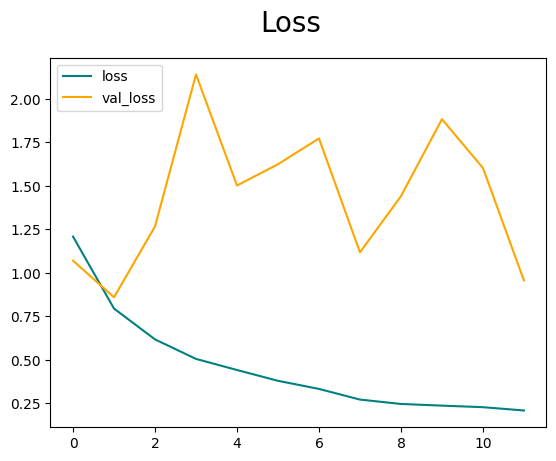

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

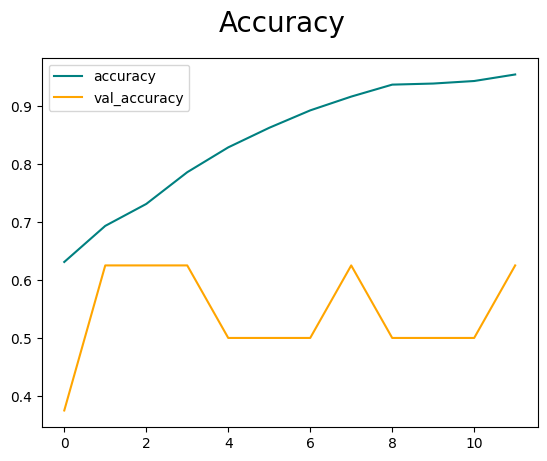

In [29]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Creating Submission

In [30]:
test_dir = 'data\\plates\\test'

In [31]:
# file names in the test directory
import os
test_files = os.listdir(test_dir)
print(test_files)

['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg', '0006.jpg', '0007.jpg', '0008.jpg', '0009.jpg', '0010.jpg', '0011.jpg', '0012.jpg', '0013.jpg', '0014.jpg', '0015.jpg', '0016.jpg', '0017.jpg', '0018.jpg', '0019.jpg', '0020.jpg', '0021.jpg', '0022.jpg', '0023.jpg', '0024.jpg', '0025.jpg', '0026.jpg', '0027.jpg', '0028.jpg', '0029.jpg', '0030.jpg', '0031.jpg', '0032.jpg', '0033.jpg', '0034.jpg', '0035.jpg', '0036.jpg', '0037.jpg', '0038.jpg', '0039.jpg', '0040.jpg', '0041.jpg', '0042.jpg', '0043.jpg', '0044.jpg', '0045.jpg', '0046.jpg', '0047.jpg', '0048.jpg', '0049.jpg', '0050.jpg', '0051.jpg', '0052.jpg', '0053.jpg', '0054.jpg', '0055.jpg', '0056.jpg', '0057.jpg', '0058.jpg', '0059.jpg', '0060.jpg', '0061.jpg', '0062.jpg', '0063.jpg', '0064.jpg', '0065.jpg', '0066.jpg', '0067.jpg', '0068.jpg', '0069.jpg', '0070.jpg', '0071.jpg', '0072.jpg', '0073.jpg', '0074.jpg', '0075.jpg', '0076.jpg', '0077.jpg', '0078.jpg', '0079.jpg', '0080.jpg', '0081.jpg', '0082.jpg', '00

In [32]:
# file formats in the test directory
test_formats = [f.split('.')[-1] for f in test_files]
print(np.unique(test_formats))

['jpg']


In [33]:
# Load the test data without expecting labels
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    labels='inferred',  # Set to 'inferred' since we don't have labels
    label_mode=None,  # No labels, so set mode to None
    color_mode='rgb',  # Assuming RGB images
    shuffle=False  # No need to shuffle test data
)

Found 744 files belonging to 1 classes.


In [34]:
# Predict the test data
predictions = model.predict(test_ds)
print(predictions)

24/24 [==============================] - 1s 21ms/step
[[3.58917296e-01]
 [2.04627006e-03]
 [9.84258175e-01]
 [6.66324273e-02]
 [1.76108722e-02]
 [2.50895740e-04]
 [1.54368975e-03]
 [1.00370520e-03]
 [9.53880232e-03]
 [5.15255379e-04]
 [5.15568117e-03]
 [6.16293773e-03]
 [6.23848734e-07]
 [2.83573405e-03]
 [1.24227711e-06]
 [9.80463564e-01]
 [8.11302185e-01]
 [9.98344183e-01]
 [7.64828324e-01]
 [1.12628037e-07]
 [1.58602193e-01]
 [3.15980590e-03]
 [1.46952271e-03]
 [3.40590195e-04]
 [1.15744560e-03]
 [1.76715339e-03]
 [9.40864254e-03]
 [2.87440321e-06]
 [9.96799111e-01]
 [6.32693758e-03]
 [4.81706262e-02]
 [1.06480950e-03]
 [1.94908027e-03]
 [8.99828598e-03]
 [2.44633313e-02]
 [2.00854212e-01]
 [8.63929279e-03]
 [2.19423564e-05]
 [2.61420816e-01]
 [1.51923094e-02]
 [2.59199470e-01]
 [3.16833874e-04]
 [3.39637101e-02]
 [1.18661467e-02]
 [1.02580700e-03]
 [2.96590477e-01]
 [1.82575884e-03]
 [3.33168893e-03]
 [1.23246377e-02]
 [1.95268393e-01]
 [1.59131475e-02]
 [3.69015569e-03]
 [3.567254

In [35]:
# Get the predicted class: 0 or 1
predicted_classes = (predictions > 0.5).astype("int32") # Convert boolean to 0 or 1
predicted_classes = predicted_classes.flatten() # Flatten to get a 1D array
print(predicted_classes)

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 

In [36]:
# create a dataframe with filenames and predictions
df = pd.DataFrame({
    'id': [x.split('.')[0] for x in test_files],
    'label': ['clean' if p == 1 else 'dirty' for p in predicted_classes]
})
df.head()

,id,label
0,0000,dirty
1,0001,dirty
2,0002,clean
3,0003,dirty
4,0004,dirty


In [37]:
df.to_csv('predictions.csv', index=False)

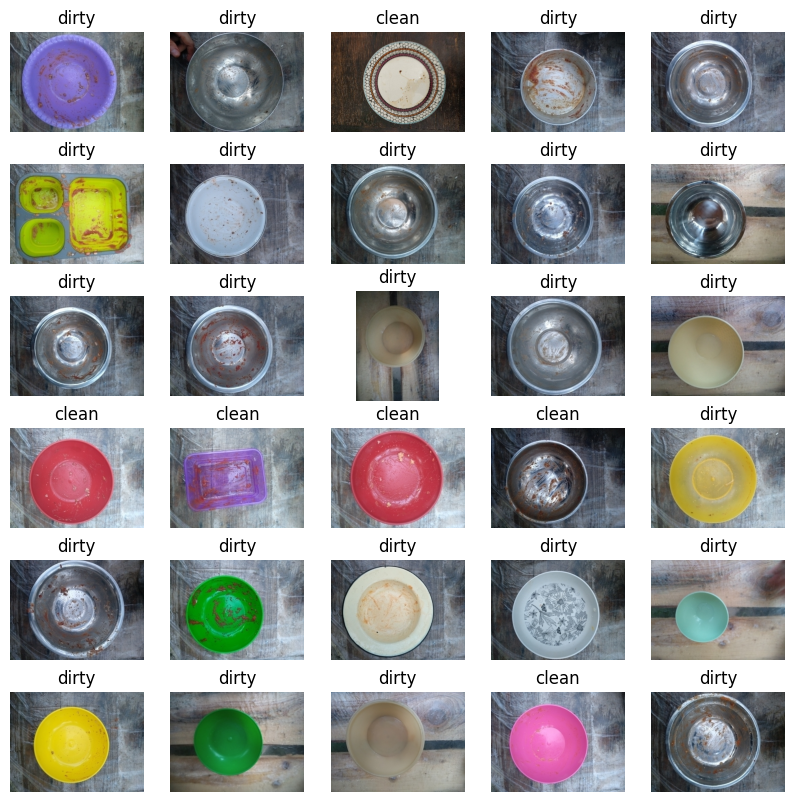

In [38]:
# plot 30 predictions images and their labels
plt.figure(figsize=(10, 10))
for i in range(30):
    ax = plt.subplot(6, 5, i + 1)
    plt.imshow(tf.keras.preprocessing.image.load_img(
        os.path.join(test_dir, test_files[i])
    ))
    plt.title(df['label'][i])
    plt.axis("off")
plt.show()
